In [30]:
import os
import librosa
import pickle
import sklearn
import numpy as np
import plotly
import optuna


from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# ! pip install optuna
# ! pip install optuna-dashboard
# ! pip install ipywidgets
# ! pip install plotly

Data from: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [14]:
train_audio_path = "C:/Users/lenovo/OneDrive/Pulpit/IB/Magisterskie/Semestr3/Głosowa Łączność z Komputerem/SpeechRecognition/SpeechRecognition/input"
commands = os.listdir(train_audio_path)
for label in commands:
    if not os.path.isdir(train_audio_path + '/' + label):
        commands.remove(label)
commands.remove('_background_noise_')  

Finding the best value of parameters

In [32]:
def Speech_Classification(n_mfcc, train_size, k, test_size, random_data_splitting=True):

    classes = []
    class_size = 100
    samples = []
    labels = []
    for command in commands:
        classes.append(command)
        sample_num = 0
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
            mean_mfcc_seq = []
            for feature in mfcc_seq:
                mean_mfcc_seq.append(np.mean(feature))
            samples.append(mean_mfcc_seq)
            labels.append(command)
            if sample_num == class_size:
                break

    if random_data_splitting:
        X = np.array(samples)
        y = np.array(labels)

        train_samples, test_samples, train_labels, test_labels = train_test_split(X, y, test_size=test_size/(train_size+test_size),
                                                                                  random_state=777, shuffle=True)
    else:
        train_samples = []
        train_labels = []
        test_samples = []
        test_labels = []
        for classname in classes:
            train_size_index = 0
            test_size_index = 0
            for i in range(len(labels)):
                if labels[i] == classname and train_size_index < train_size:
                    train_samples.append(samples[i])
                    train_labels.append(labels[i])
                    train_size_index += 1
                elif labels[i] == classname and test_size_index < test_size:
                    test_samples.append(samples[i])
                    test_labels.append(labels[i])
                    test_size_index += 1
                if train_size_index == train_size and test_size_index == test_size:
                    break

                
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)

    classifier = KNeighborsClassifier(n_neighbors = k)
    
    return classifier, train_samples, train_labels, test_samples, test_labels
    

In [33]:
def objective(trial):
    params = {
        'n_mfcc' : trial.suggest_int('n_mfcc', 1, 100),
        'train_size' : trial.suggest_int('train_size', 1, 100),
        'k' : trial.suggest_int('k', 1, 10),
        'test_size' : 10 #Fixed
     }
    
    model, train_samples, train_labels, test_samples, test_labels = Speech_Classification(**params)
    model.fit(train_samples, train_labels)
    
    predicted_labels = model.predict(test_samples)
    quality = np.sum(test_labels == predicted_labels) / len(test_labels) * 100
    
    return quality

study = optuna.create_study(direction = 'maximize')
study.optimize(objective,n_trials = 100)

[I 2025-06-12 23:12:01,919] A new study created in memory with name: no-name-2286decf-8cec-4931-b2a4-24270c71f8e3
[I 2025-06-12 23:12:18,063] Trial 0 finished with value: 21.98581560283688 and parameters: {'n_mfcc': 26, 'train_size': 61, 'k': 7}. Best is trial 0 with value: 21.98581560283688.
[I 2025-06-12 23:12:33,813] Trial 1 finished with value: 25.986842105263158 and parameters: {'n_mfcc': 12, 'train_size': 89, 'k': 5}. Best is trial 1 with value: 25.986842105263158.
[I 2025-06-12 23:12:49,874] Trial 2 finished with value: 7.9178885630498534 and parameters: {'n_mfcc': 2, 'train_size': 78, 'k': 6}. Best is trial 1 with value: 25.986842105263158.
[I 2025-06-12 23:13:06,529] Trial 3 finished with value: 20.623916811091856 and parameters: {'n_mfcc': 10, 'train_size': 3, 'k': 1}. Best is trial 1 with value: 25.986842105263158.
[I 2025-06-12 23:13:23,690] Trial 4 finished with value: 30.25540275049116 and parameters: {'n_mfcc': 40, 'train_size': 49, 'k': 2}. Best is trial 4 with value: 3

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18328\1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

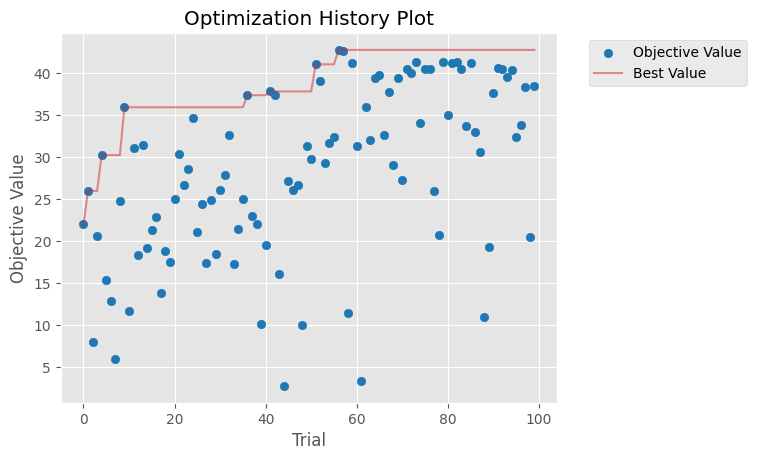

In [34]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [36]:
print("Best value: ", study.best_trial.value, "with following hyperparameters: ", study.best_trial.params)

Best value:  42.8 with following hyperparameters:  {'n_mfcc': 14, 'train_size': 30, 'k': 1}


In [11]:
best_quality, best_mfcc = 0., 1
for n_mfcc in range(1, 101):
    print("Processing n_mfcc = {}, best n_mff so far is {} with quality: {:.2f}".format(n_mfcc, best_mfcc, best_quality))
    classes = []
    class_size = 100
    samples = []
    labels = []
    for command in commands:
        classes.append(command)
        sample_num = 0
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
            mean_mfcc_seq = []
            for feature in mfcc_seq:
                mean_mfcc_seq.append(np.mean(feature))
            samples.append(mean_mfcc_seq)
            labels.append(command)
            if sample_num == class_size:
                break

    # database = open('database.pkl', 'wb')
    # pickle.dump([classes, samples, labels], database)
    # database.close()

    # database = open('database.pkl', 'rb')
    # classes, samples, labels = pickle.load(database)
    # database.close()

    train_size = 40
    test_size = 10
    train_samples = []
    train_labels = []
    test_samples = []
    test_labels = []
    for classname in classes:
        train_size_index = 0
        test_size_index = 0
        for i in range(len(labels)):
            if labels[i] == classname and train_size_index < train_size:
                train_samples.append(samples[i])
                train_labels.append(labels[i])
                train_size_index += 1
            elif labels[i] == classname and test_size_index < test_size:
                test_samples.append(samples[i])
                test_labels.append(labels[i])
                test_size_index += 1
            if train_size_index == train_size and test_size_index == test_size:
                break
                
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)

    k = 5
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_samples, train_labels)

    predicted_labels = classifier.predict(test_samples)
        
    # zobaczmy wynik - zakomentować dla dużych zbiorów
    # print(test_labels)
    # print(predicted_labels)


    # 5. Ocena klasyfikatora
    # print(test_labels == predicted_labels)
    quality = np.sum(test_labels == predicted_labels) / len(test_labels) * 100
    
    if best_quality < quality:
        best_quality = quality
        best_mfcc = n_mfcc

    # print('Ocena klasyfikatora: %.2f %%' % quality)

Processing n_mfcc = 1, best n_mff so far is 1 with quality: 0.00


NameError: name 'commands' is not defined

In [ ]:
print("The best quality {:.2f} is for mfcc={}".format(best_quality, best_mfcc))

The best quality 12.00 is for mfcc=9


Finding the best number of train size

In [ ]:
best_quality, best_train_size = 0., 1
n_mfcc = 9
for train_size in range(1, 101):
    print("Processing train_size = {}, best train_size so far is {} with quality: {:.2f}".format(train_size, best_train_size, best_quality))
    classes = []
    class_size = 100
    samples = []
    labels = []
    for command in commands:
        classes.append(command)
        sample_num = 0
        for file in os.listdir(train_audio_path + '/' + command + '/'):
            sample_num += 1
            y, sr = librosa.load(train_audio_path + '/' + command + '/' + file)
            mfcc_seq = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = n_mfcc)
            mean_mfcc_seq = []
            for feature in mfcc_seq:
                mean_mfcc_seq.append(np.mean(feature))
            samples.append(mean_mfcc_seq)
            labels.append(command)
            if sample_num == class_size:
                break

    # database = open('database.pkl', 'wb')
    # pickle.dump([classes, samples, labels], database)
    # database.close()

    # database = open('database.pkl', 'rb')
    # classes, samples, labels = pickle.load(database)
    # database.close()

    test_size = 10
    train_samples = []
    train_labels = []
    test_samples = []
    test_labels = []
    for classname in classes:
        train_size_index = 0
        test_size_index = 0
        for i in range(len(labels)):
            if labels[i] == classname and train_size_index < train_size:
                train_samples.append(samples[i])
                train_labels.append(labels[i])
                train_size_index += 1
            elif labels[i] == classname and test_size_index < test_size:
                test_samples.append(samples[i])
                test_labels.append(labels[i])
                test_size_index += 1
            if train_size_index == train_size and test_size_index == test_size:
                break
                
    scaler = StandardScaler()
    scaler.fit(train_samples)
    train_samples = scaler.transform(train_samples)
    test_samples = scaler.transform(test_samples)

    k = 5
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_samples, train_labels)

    predicted_labels = classifier.predict(test_samples)
        
    # zobaczmy wynik - zakomentować dla dużych zbiorów
    # print(test_labels)
    # print(predicted_labels)


    # 5. Ocena klasyfikatora
    # print(test_labels == predicted_labels)
    quality = np.sum(test_labels == predicted_labels) / len(test_labels) * 100
    
    if best_quality < quality:
        best_quality = quality
        best_train_size = train_size

    # print('Ocena klasyfikatora: %.2f %%' % quality)

Processing train_size = 1, best train_size so far is 1 with quality: 0.00
Processing train_size = 2, best train_size so far is 1 with quality: 2.33
Processing train_size = 3, best train_size so far is 2 with quality: 5.00
Processing train_size = 4, best train_size so far is 2 with quality: 5.00
Processing train_size = 5, best train_size so far is 4 with quality: 6.67
Processing train_size = 6, best train_size so far is 4 with quality: 6.67
Processing train_size = 7, best train_size so far is 4 with quality: 6.67
Processing train_size = 8, best train_size so far is 7 with quality: 8.33
Processing train_size = 9, best train_size so far is 8 with quality: 10.00
Processing train_size = 10, best train_size so far is 8 with quality: 10.00
Processing train_size = 11, best train_size so far is 10 with quality: 10.33
Processing train_size = 12, best train_size so far is 11 with quality: 14.67
Processing train_size = 13, best train_size so far is 12 with quality: 16.33
Processing train_size = 14

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.